In [1]:
import os
os.chdir('../../')

In [2]:
from common.data.data_preprocess import preprocess_data
from common.computils.solutions import load_data
from common.computils.misc import tf115_found, fix_all_random_seeds, temp_seed_numpy, in_progress

from torch.utils.data import DataLoader

import torch
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2

TensorFlow 1.15 not found.


In [3]:
data_path = "starting_kit/data/train_longitudinal_data.csv"
data_dir = os.path.dirname(data_path)
data_file_name = os.path.basename(data_path)
max_seq_len = 100
seed = 0
train_frac = 0.5
debug_data = 1000000

with in_progress("Preprocessing and loading data"):
        original_data, original_padding_mask, train_idx, test_idx = load_data(
            data_dir=data_dir,
            data_file_name=data_file_name,
            max_seq_len=max_seq_len,
            seed=seed,
            train_rate=train_frac,
            force_reprocess=True,  # If True, re-preprocess data every time (rather than reusing).
            debug_data=debug_data,
        )
original_data_train = original_data[train_idx]
original_padding_mask_train = original_padding_mask[train_idx]
hider_input = {"data": original_data_train, "seed": seed, "padding_mask": original_padding_mask_train}
print(original_data.shape, original_data_train.shape)

Preprocessing and loading data...


100%|██████████| 597/597 [00:01<00:00, 425.19it/s]


Preprocessing and loading data DONE
(597, 100, 71) (298, 100, 71)


In [4]:
seed = hider_input["seed"]  # Random seed provided by the competition, use for reproducibility.
data = hider_input["data"]  # Input data, shape [num_examples, max_seq_len, num_features].
padding_mask = hider_input["padding_mask"]
data_preproc, data_imputed = preprocess_data(data, padding_mask)

In [80]:
from common.hider.geSnds.utils import AmdbSimpleDataset, preproc_vae, plot_learning_history
from torch.utils.data import random_split

In [81]:
batch_size = 32

print("Preparing data for VAE")
vae_data = preproc_vae(data_preproc)
dataset = AmdbSimpleDataset(vae_data)

train_len = 4*len(dataset)//5
val_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len], generator=torch.Generator().manual_seed(seed))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
assert len(dataset.data.shape), "Vae dataset should be 2 dimensionnal, got dimensions : {}".format(dataset.data.shape)

Preparing data for VAE


In [84]:
from common.hider.geSnds.vaeRepeat import VAE, trainVAE
from torch.optim import Adam

hidden_dims = (30, )
n_epochs = 10
print_every_epochs = 1

vae = VAE(dataset.data.shape[1], hidden_dims)
optimizer = Adam(vae.parameters(), lr=0.001)

In [85]:
train_loss_history, val_loss_history = trainVAE(vae, train_loader, val_loader, optimizer, n_epochs, print_every_epochs)

Epoch: 0 Average training loss: 0.0482, average validation loss: 0.0206
Epoch: 1 Average training loss: 0.0075, average validation loss: 0.0106
Epoch: 2 Average training loss: 0.0027, average validation loss: 0.0033
Epoch: 3 Average training loss: 0.0021, average validation loss: 0.0016
Epoch: 4 Average training loss: 0.0011, average validation loss: 0.0012
Epoch: 5 Average training loss: 0.0009, average validation loss: 0.0009
Epoch: 6 Average training loss: 0.0008, average validation loss: 0.0007
Epoch: 7 Average training loss: 0.0007, average validation loss: 0.0006
Epoch: 8 Average training loss: 0.0008, average validation loss: 0.0006
Epoch: 9 Average training loss: 0.0008, average validation loss: 0.0006


[1.54467582 0.2409139  0.08610015 0.06599427 0.03656388 0.03041874
 0.0265026  0.02319822 0.02536601 0.02676761]


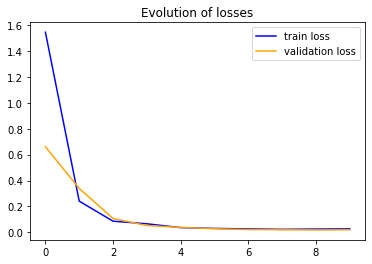

In [86]:
print(train_loss_history)
plot_learning_history(train_loss_history, val_loss_history)

# debug vae

It seems that vae pushes some dimensions of the outputs to extrem values.

In [28]:
# one example
batch, missing_mask, padding_mask = next(iter(train_loader))
batch

tensor([[6.0000e+00, 6.4889e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.6000e+02, 3.7333e-01, 4.3243e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.3620e+03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.6000e+02, 3.5111e-01, 4.4595e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [29]:
from common.hider.geSnds.vaeRepeat import loss_function
recon_batch, mu, logvar = vae(batch)
loss = loss_function(
    recon_batch * (1- missing_mask) * (1 - padding_mask), 
    batch * (1- missing_mask) * (1 - padding_mask),  
    mu, logvar)
loss

tensor(inf, grad_fn=<AddBackward0>)

In [30]:
print(torch.isinf(recon_batch).sum())
torch.isinf(recon_batch**2).sum()

tensor(0)


tensor(0)

In [31]:
print((recon_batch > 1000).sum(axis=0))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [32]:
(recon_batch > 1000).sum(axis=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
ix = 0
print(batch[ix])
recon_batch[ix]

tensor([6.0000, 0.6489, 0.0000, 0.0000, 0.0000, 0.4800, 0.0000, 0.0000, 0.9277,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4521, 0.2685,
        0.2220, 0.3725, 1.0000, 0.0000, 0.6000, 0.0000, 0.2500, 0.0000, 0.0000,
        0.5556, 0.2500, 0.0000, 0.0000, 0.2685, 0.3077, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


tensor([0.4303, 0.6274, 0.0000, 0.4779, 0.0000, 0.0000, 0.5568, 0.0000, 0.0000,
        0.0000, 0.0939, 0.0000, 0.4377, 0.0000, 0.7923, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2025, 0.0000, 0.2387, 0.0000, 0.0000, 0.3625, 0.1085,
        0.0000, 0.0000, 0.0650, 0.2441, 0.0000, 0.3852, 0.8756, 0.4966, 0.0000,
        0.7896, 0.4847, 0.0000, 0.5555, 0.0000, 0.0000, 0.0000, 0.7427, 0.0000,
        0.0000, 0.0000, 0.0000, 0.5810, 0.5984, 0.0931, 0.0000, 0.3208, 0.0000,
        0.5948, 0.0000, 0.0000, 0.0000, 0.7415, 0.8085, 0.4315, 0.0902, 0.0000,
        0.0000, 0.0000, 0.0000, 0.2549, 0.2370, 0.0000, 0.0595, 0.0000],
       grad_fn=<SelectBackward>)